In [1]:
import matplotlib.pyplot as plt
# os.chdir('/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/notebooks/BasicTS/')
from utils import init, get_predictions
import os
os.chdir('/pfs/data6/home/ma/ma_ma/ma_kreffert/Probabilistic_LTSF/BasicTS/')
from prob.prob_head import ProbabilisticHead
path= '6f0ff289427f26b39444d02254fe169c'#'27d40957374f98d2d16be997f2c114de'
cfg_path = "final_weights/ETTh1_prob.py"
path = "Probabilistic_LTSF/model_weights/gaussian_PatchTST/ETTh1_100_96_720/fe6403be50fc51cc44177cf319d0083f"

runner = init(model='PatchTST', dataset='ETTh1_prob', path=path, no_logging=False, cfg_path=cfg_path)

2025-05-20 13:39:13.534570: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 13:39:16.257255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747741157.180061 1768299 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747741157.516030 1768299 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 13:39:19.981912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

DESCRIPTION: An Example Config
GPU_NUM: 1
RUNNER: <class 'basicts.runners.runner_zoo.simple_prob_tsf_runner.SimpleProbTimeSeriesForecastingRunner'>
USE_WANDB: False
DATASET:
  NAME: ETTh1
  TYPE: <class 'basicts.data.simple_tsf_dataset.TimeSeriesForecastingDataset'>
  PARAM:
    dataset_name: ETTh1
    train_val_test_ratio: [0.6, 0.2, 0.2]
    input_len: 96
    output_len: 720
SCALER:
  TYPE: <class 'basicts.scaler.z_score_scaler.ZScoreScaler'>
  PARAM:
    dataset_name: ETTh1
    train_ratio: 0.6
    norm_each_channel: True
    rescale: False
MODEL:
  NAME: PatchTST
  ARCH: <class 'baselines.PatchTST.arch.patchtst_arch.PatchTST'>
  PARAM:
    enc_in: 7
    seq_len: 96
    pred_len: 720
    e_layers: 2
    n_heads: 2
    d_model: 32
    d_ff: 32
    dropout: 0.3
    fc_dropout: 0.3
    head_dropout: 0.0
    patch_len: 32
    stride: 64
    individual: 1
    padding_patch: end
    revin: 1
    affine: 1
    subtract_last: 1
    decomposition: 1
    kernel_size: 25
    head_type: probabi

2025-05-20 13:39:49,204 - easytorch-training - INFO - Initializing training.
2025-05-20 13:39:49,206 - easytorch-training - INFO - Set clip grad, param: {'max_norm': 5.0}
2025-05-20 13:39:49,206 - easytorch-training - INFO - Building training data loader.
2025-05-20 13:39:49,210 - easytorch-training - INFO - Train dataset length: 7825


PatchTST


/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/bwhpc/common/jupyter/ai/2025-02-20/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025-05-20 13:40:04,080 - easytorch-training - INFO - Set optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_de

In [2]:
predictions, past_actuals, future_actuals = get_predictions(runner, data_loader="test")
print(f"Num Windows {future_actuals.shape[0]}")
print(f"Input Horizon {past_actuals.shape[1]}")
print(f"Prediction Horizon {future_actuals.shape[1]}")
print(f"Num Series {future_actuals.shape[2]}")

33it [00:02, 14.88it/s]


Num Windows 2065
Input Horizon 96
Prediction Horizon 720
Num Series 7


In [3]:
print(runner.model.distribution_type)

gaussian


In [4]:
from prob.prob_head import ProbabilisticHead
import torch
prob_head = ProbabilisticHead(1, 1, runner.model.distribution_type, prob_args=runner.prob_args)
distribution = prob_head.__get_dist__(torch.tensor(predictions))
print(distribution)

Normal(loc: torch.Size([2065, 720, 7]), scale: torch.Size([2065, 720, 7]))


In [5]:
logp = distribution.log_prob(torch.tensor(future_actuals[..., 0]))
print(-torch.mean(logp))

tensor(2.5105)


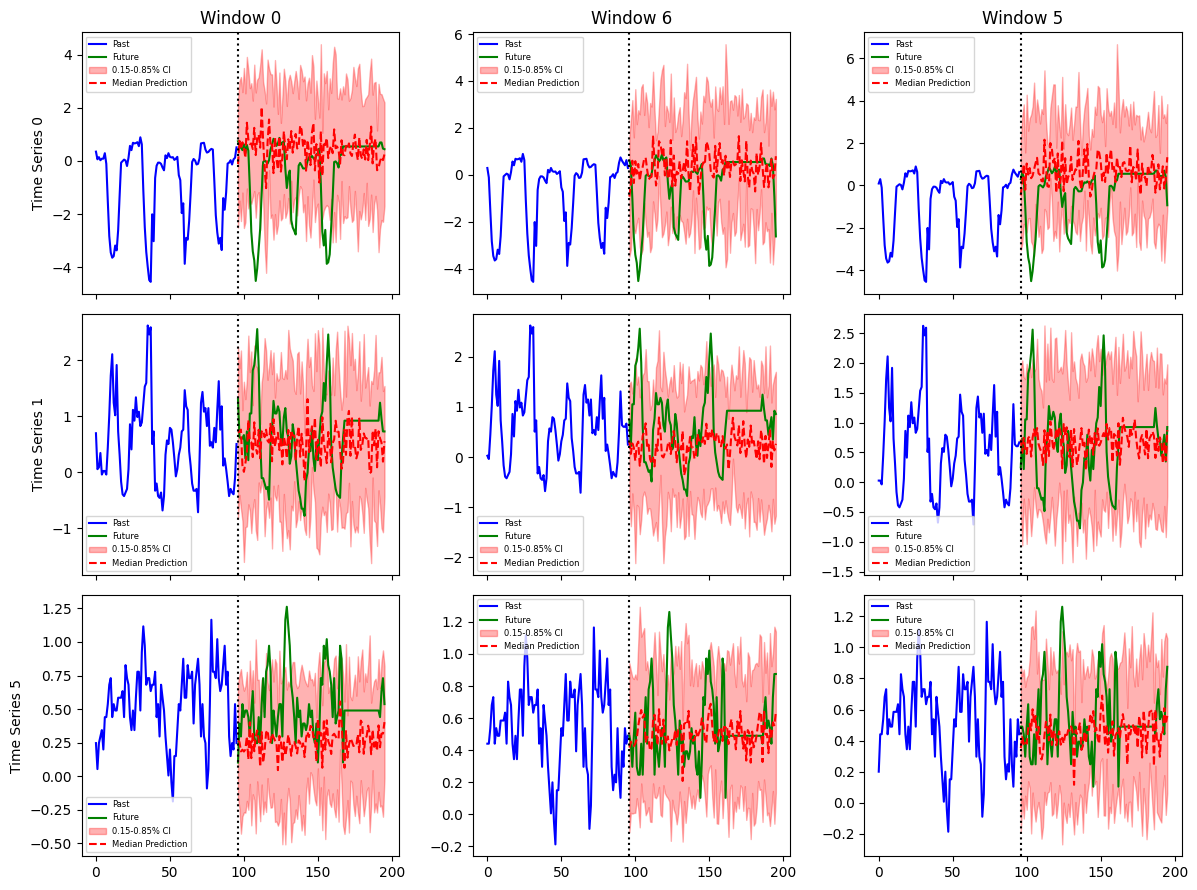

In [6]:
import seaborn as sns
def plot_predictions(predictions, window, serie, ax, ci=None, quantile_levels=[]):
    if ci != None:
        if len(quantile_levels)>1: # quantile forecast
            ci = [i / 100 if i > 1 else i for i in ci]
            assert ci[0] in quantile_levels
            assert ci[1]in quantile_levels
            assert 0.5 in quantile_levels 
            lower_bound = predictions[window, :, serie, quantile_levels.index(ci[0])]
            upper_bound = predictions[window, :, serie, quantile_levels.index(ci[1])]
            median_pred = predictions[window, :, serie, quantile_levels.index(0.5)]
        else:# non quantile prob forecast -> need to calculate the quantiles first
            # Extract mean and std
            median_pred = predictions[window, :, serie, 0]  # Shape: [num_time_steps]
            std = predictions[window, :, serie, 1]   # Shape: [num_time_steps]
            
            # Create a grid of x values
            #x = range(predictions.shape[1])
            # Compute the PDFs for all time steps at once
            #pdfs = norm.pdf(x, loc=median_pred, scale=std)  # Shape: [num_points, num_time_steps]
            
            #ax.plot(x, pdfs)#label=[f"Time Step {t+1} (μ={mean[t]}, σ={std[t]})" for t in range(predictions.shape[0])])
            
            lower_bound = median_pred + 2*std #np.percentile(predictions[window, :, :, serie], ci[0], axis=0)
            upper_bound = median_pred - 2*std #np.percentile(predictions[window, :, :, serie], ci[1], axis=0)
            #median_pred = np.percentile(predictions[window, :, :, serie], 50, axis=0)

        pred_range = range(len(past_actuals[window]), len(past_actuals[window]) + len(median_pred))
        ax.fill_between(pred_range, lower_bound, upper_bound, color='red', alpha=0.3, label=f"{ci[0]}-{ci[1]}% CI")
        ax.plot(pred_range, median_pred, color='red', linestyle='dashed', label="Median Prediction")
    else:# point or sample forecasts
        if len(predictions.squeeze().shape) >3:
            batches, num_samples, pred_length, num_series = predictions.shape
            palette = sns.color_palette("deep", n_colors=7)[1:]  # Change the number to match your series count
            line_styles = ['-', '--', '-.', ':', '-', '--', '-.']  # Different line styles
            num_samples = 2
            for i in range(num_samples):
                ax.plot(range(len(past_actuals[window]), len(past_actuals[window]) + pred_length),
                    predictions[window, i, :, serie], color=palette[i % len(palette)], linestyle=line_styles[i % len(line_styles)], label=f'Series {i+1}', alpha=0.7)
        else:
            ax.plot(range(len(past_actuals[window]), len(past_actuals[window]) + len(predictions[window])),
                predictions[window, :, serie], label="Prediction", color='orange', linestyle='dashed')



def plot_time_series_1(past_actuals, future_actuals, predictions, windows, series, ci=[5, 95], quantile_levels=[], future_steps=None):
    if future_steps is not None:
        future_actuals = future_actuals[:, :future_steps, :]
        predictions = predictions[:, :future_steps, :, :]
    num_rows = len(series)  # One row per feature
    num_cols = len(windows)  # One column per time series index

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3), sharex=True, sharey=False)

    if num_rows == 1 or num_cols == 1:
        axes = np.array(axes).reshape(num_rows, num_cols)  # Ensure 2D indexing

    for row, serie in enumerate(series):
        for col, window in enumerate(windows):
            ax = axes[row, col]  # Get the correct subplot

            # Plot past actuals
            ax.plot(range(len(past_actuals[window])), past_actuals[window, :, serie], label="Past", color='blue')

            # Plot future actuals
            ax.plot(range(len(past_actuals[window]), len(past_actuals[window]) + len(future_actuals[window])),
                    future_actuals[window, :, serie], label="Future", color='green')
            
            plot_predictions(predictions, window, serie, ax, ci=ci, quantile_levels=quantile_levels)
            
            ax.axvline(x=len(past_actuals[window]), color='black', linestyle='dotted')  # Mark forecast start
            if row == 0:
                ax.set_title(f"Window {window}")
            if col == 0:
                ax.set_ylabel(f"Time Series {serie}")
            ax.legend(fontsize=6)
    plt.tight_layout()
    plt.show()

windows = [0, 6, 5]
series = [0, 1, 5]
# plot_time_series(past_actuals, future_actuals, predictions, windows, series, ci=(0.05, 0.95), quantile_levels=[])
plot_time_series_1(past_actuals, future_actuals, predictions, windows, series, ci=(0.15, 0.85), quantile_levels=[], future_steps=100)

torch.Size([3, 100, 4, 5])


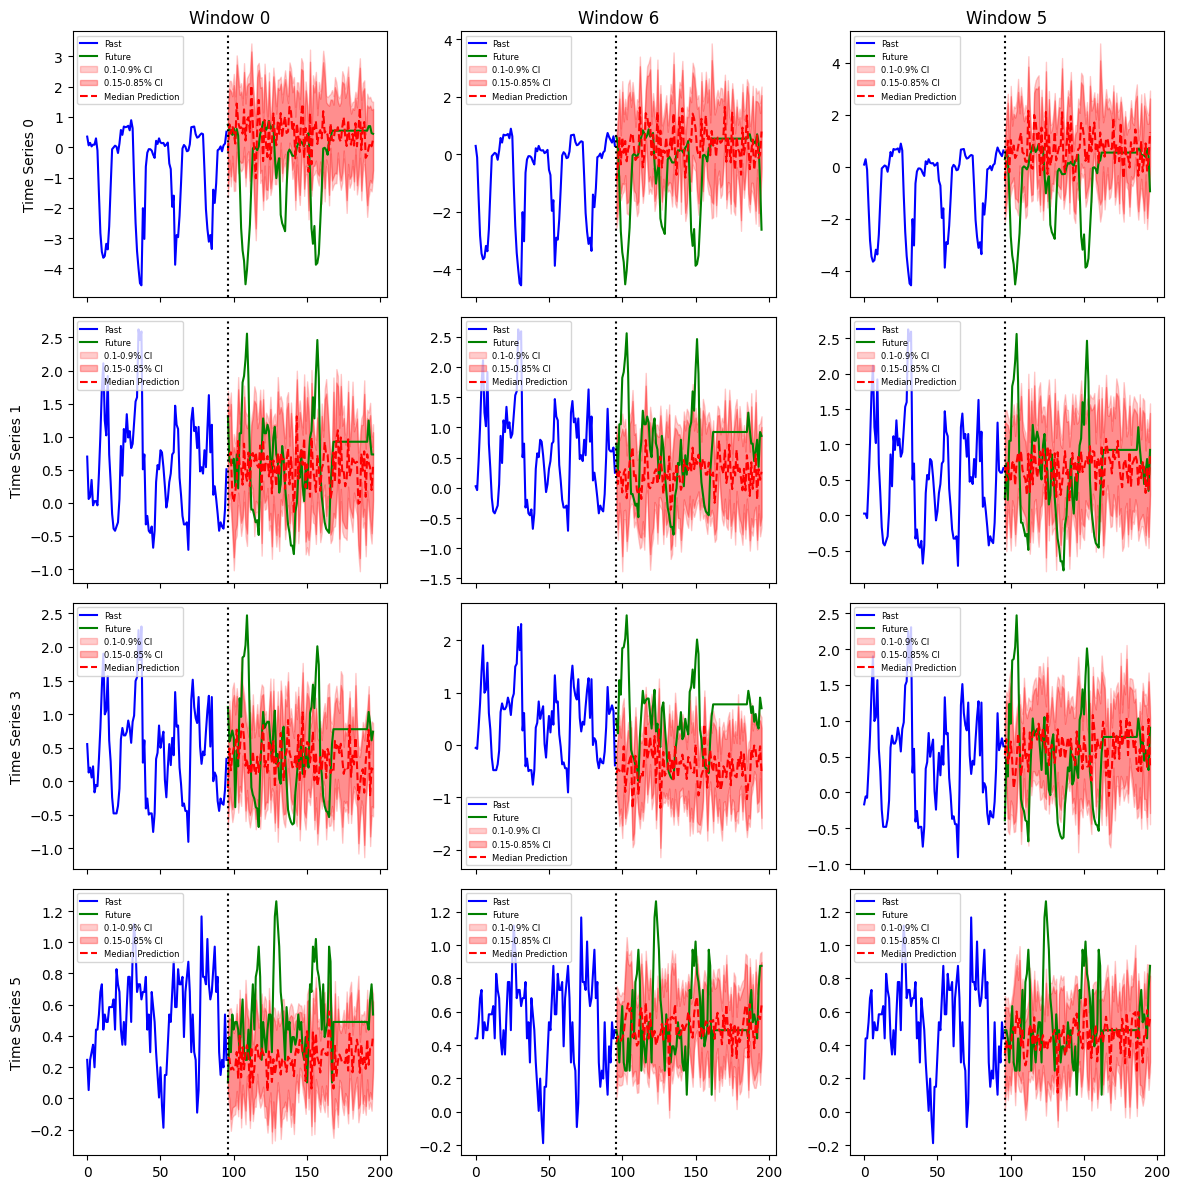

In [45]:
import seaborn as sns
import numpy as np
def get_quantiles(predictions, runner, windows, series, quantile_levels=[]):
    from prob.prob_head import ProbabilisticHead
    import torch
    if runner.model.distribution_type in ['gaussian', 'laplace', 'student_t']:
        prob_head = ProbabilisticHead(1, 1, runner.model.distribution_type, prob_args=runner.prob_args)
        distribution = prob_head.__get_dist__(torch.tensor(predictions[windows][:, :, series, :]))
        quantiles = []
        for q in quantile_levels:
            quantiles.append(distribution.icdf(torch.tensor(q).reshape(-1, 1, 1)))
        quantiles = torch.stack(quantiles, dim=-1)
        return quantiles

def plot_predictions(runner, predictions, window, serie, ax, ci=None, quantile_levels=[], quantiles=None):
    if ci != None:
        if runner.model.distribution_type == "quantile":
            # if len(quantile_levels)>1: # quantile forecast
            ci = [i / 100 if i > 1 else i for i in ci]
            assert ci[0] in quantile_levels
            assert ci[1]in quantile_levels
            assert 0.5 in quantile_levels 
            lower_bound = predictions[window, :, serie, quantile_levels.index(ci[0])]
            upper_bound = predictions[window, :, serie, quantile_levels.index(ci[1])]
            median_pred = predictions[window, :, serie, quantile_levels.index(0.5)]
        else:# non quantile prob forecast -> need to calculate the quantiles first
            trajectories = dict()
            if quantiles is None:
                # Extract mean and std
                trajectories[0.5] = predictions[window, :, serie, 0]  # Shape: [num_time_steps]
                std = predictions[window, :, serie, 1]   # Shape: [num_time_steps]
                
                # Create a grid of x values
                #x = range(predictions.shape[1])
                # Compute the PDFs for all time steps at once
                #pdfs = norm.pdf(x, loc=median_pred, scale=std)  # Shape: [num_points, num_time_steps]
                
                #ax.plot(x, pdfs)#label=[f"Time Step {t+1} (μ={mean[t]}, σ={std[t]})" for t in range(predictions.shape[0])])
                
                trajectories[0.95] = median_pred + 2*std #np.percentile(predictions[window, :, :, serie], ci[0], axis=0)
                trajectories[0.05] = median_pred - 2*std #np.percentile(predictions[window, :, :, serie], ci[1], axis=0)
                #median_pred = np.percentile(predictions[window, :, :, serie], 50, axis=0)
            else:
                for quantile in quantile_levels:
                    trajectories[quantile] = quantiles[window, :, serie, quantile_levels.index(quantile)]
   
        pred_range = range(len(past_actuals[window]), len(past_actuals[window]) + predictions.shape[1])

        _q_list = [(q, 1-q) for q in trajectories.keys() if q<0.5]
        _q_list.append(0.5) 
        for qs in _q_list:
            if qs != 0.5:
                assert qs[1] == 1-qs[0]
                ax.fill_between(pred_range, trajectories[qs[0]], trajectories[1-qs[0]], color='red', alpha=2*qs[0], label=f"{qs[0]}-{1-qs[0]}% CI")
            else:
                ax.plot(pred_range, trajectories[0.5], color='red', linestyle='dashed', label="Median Prediction")
    else:# point or sample forecasts
        if len(predictions.squeeze().shape) >3:
            batches, num_samples, pred_length, num_series = predictions.shape
            palette = sns.color_palette("deep", n_colors=7)[1:]  # Change the number to match your series count
            line_styles = ['-', '--', '-.', ':', '-', '--', '-.']  # Different line styles
            num_samples = 2
            for i in range(num_samples):
                ax.plot(range(len(past_actuals[window]), len(past_actuals[window]) + pred_length),
                    predictions[window, i, :, serie], color=palette[i % len(palette)], linestyle=line_styles[i % len(line_styles)], label=f'Series {i+1}', alpha=0.7)
        else:
            ax.plot(range(len(past_actuals[window]), len(past_actuals[window]) + len(predictions[window])),
                predictions[window, :, serie], label="Prediction", color='orange', linestyle='dashed')



def plot_time_series_1(runner, past_actuals, future_actuals, predictions, windows, series, ci=[5, 95], quantile_levels=[], future_steps=None):
    if future_steps is not None:
        future_actuals = future_actuals[:, :future_steps, :]
        predictions = predictions[:, :future_steps, :, :]
    num_rows = len(series)  # One row per feature
    num_cols = len(windows)  # One column per time series index

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3), sharex=True, sharey=False)
    if (len(quantile_levels)<1) and (len(ci)>0):
        quantile_levels = [i / 100 if i > 1 else i for i in ci]
    quantiles = get_quantiles(predictions, runner, windows, series, quantile_levels=quantile_levels)
    print(quantiles.shape)
    if num_rows == 1 or num_cols == 1:
        axes = np.array(axes).reshape(num_rows, num_cols)  # Ensure 2D indexing

    for row, serie in enumerate(series):
        for col, window in enumerate(windows):
            ax = axes[row, col]  # Get the correct subplot

            # Plot past actuals
            ax.plot(range(len(past_actuals[window])), past_actuals[window, :, serie], label="Past", color='blue')

            # Plot future actuals
            ax.plot(range(len(past_actuals[window]), len(past_actuals[window]) + len(future_actuals[window])),
                    future_actuals[window, :, serie], label="Future", color='green')
            if quantiles is not None:
                plot_predictions(runner, predictions, windows.index(window), series.index(serie), ax, ci=ci, quantile_levels=quantile_levels, quantiles=quantiles)
            else:
                plot_predictions(runner, predictions, window, serie, ax, ci=ci, quantile_levels=quantile_levels)
            ax.axvline(x=len(past_actuals[window]), color='black', linestyle='dotted')  # Mark forecast start
            if row == 0:
                ax.set_title(f"Window {window}")
            if col == 0:
                ax.set_ylabel(f"Time Series {serie}")
            ax.legend(fontsize=6)
    plt.tight_layout()
    plt.show()

windows = [0, 6, 5]
series = [0, 1, 3, 5]
# plot_time_series(past_actuals, future_actuals, predictions, windows, series, ci=(0.05, 0.95), quantile_levels=[])
plot_time_series_1(runner, past_actuals, future_actuals, predictions, windows, series, ci=(0.1, 0.15, 0.5, 0.85, 0.9), quantile_levels=[], future_steps=100)

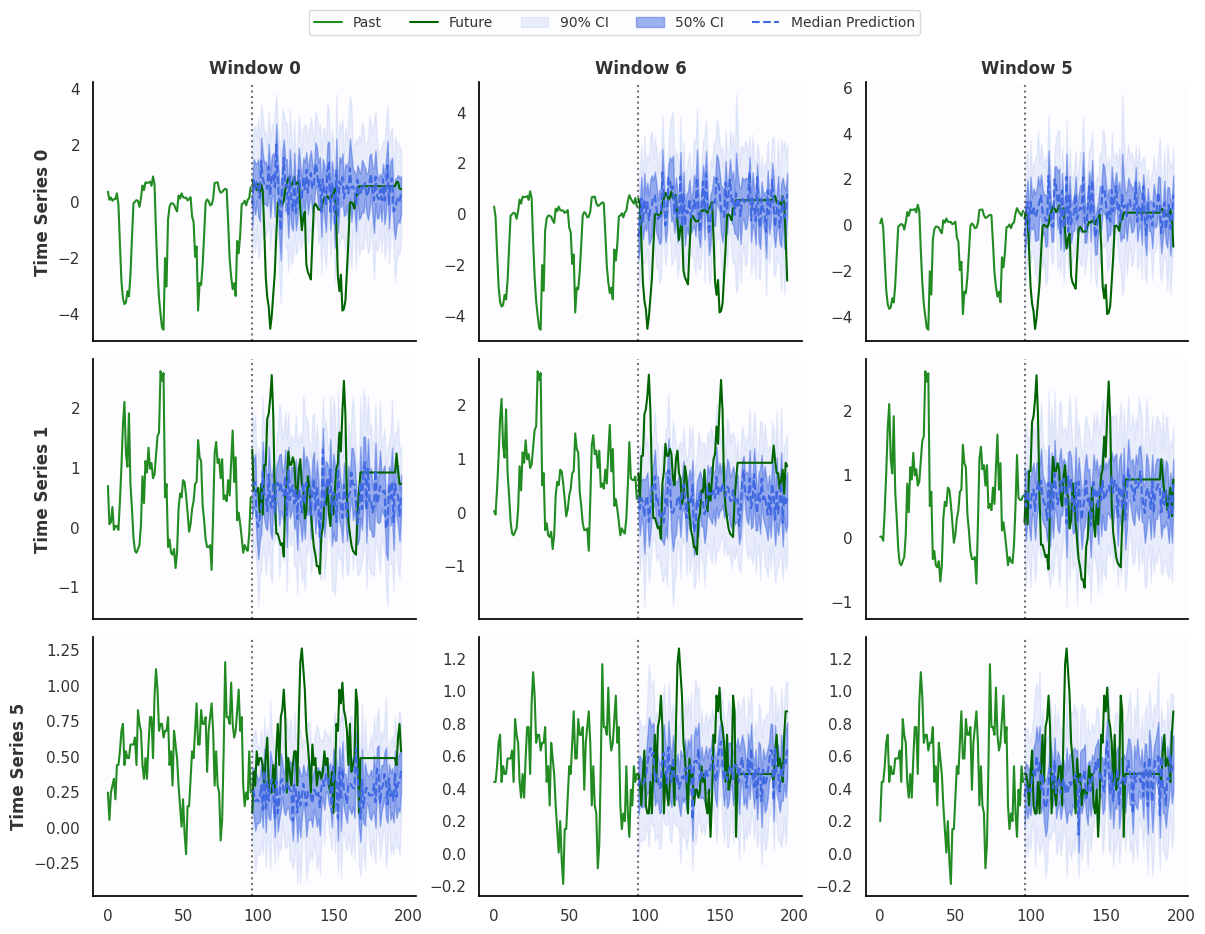

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import seaborn as sns
import numpy as np
def get_quantiles(predictions, runner, windows, series, quantile_levels=[]):
    from prob.prob_head import ProbabilisticHead
    import torch
    if runner.model.distribution_type in ['gaussian', 'laplace', 'student_t']:
        prob_head = ProbabilisticHead(1, 1, runner.model.distribution_type, prob_args=runner.prob_args)
        distribution = prob_head.__get_dist__(torch.tensor(predictions[windows][:, :, series, :]))
        quantiles = []
        for q in quantile_levels:
            quantiles.append(distribution.icdf(torch.tensor(q).reshape(-1, 1, 1)))
        quantiles = torch.stack(quantiles, dim=-1)
        return quantiles


def plot_predictions(runner, predictions, window, serie, ax, ci=None, quantile_levels=[], quantiles=None, c_palette=None):
    """Plot predictions with confidence intervals using Seaborn styling."""
    # Set the Seaborn style
    # sns.set_style("whitegrid")

    
    if ci is not None:
        if runner.model.distribution_type == "quantile":  # quantile forecast
            ci = [i / 100 if i > 1 else i for i in ci]
            assert ci[0] in quantile_levels
            assert ci[1] in quantile_levels
            assert 0.5 in quantile_levels 
            lower_bound = predictions[window, :, serie, quantile_levels.index(ci[0])]
            upper_bound = predictions[window, :, serie, quantile_levels.index(ci[1])]
            median_pred = predictions[window, :, serie, quantile_levels.index(0.5)]
        else:# non quantile prob forecast -> need to calculate the quantiles first
            trajectories = dict()
            if quantiles is None:
                # Extract mean and std
                trajectories[0.5] = predictions[window, :, serie, 0]  # Shape: [num_time_steps]
                std = predictions[window, :, serie, 1]   # Shape: [num_time_steps]
                
                # Create a grid of x values
                #x = range(predictions.shape[1])
                # Compute the PDFs for all time steps at once
                #pdfs = norm.pdf(x, loc=median_pred, scale=std)  # Shape: [num_points, num_time_steps]
                
                #ax.plot(x, pdfs)#label=[f"Time Step {t+1} (μ={mean[t]}, σ={std[t]})" for t in range(predictions.shape[0])])
                
                trajectories[0.95] = median_pred + 2*std #np.percentile(predictions[window, :, :, serie], ci[0], axis=0)
                trajectories[0.05] = median_pred - 2*std #np.percentile(predictions[window, :, :, serie], ci[1], axis=0)
                #median_pred = np.percentile(predictions[window, :, :, serie], 50, axis=0)
            else:
                for quantile in quantile_levels:
                    trajectories[quantile] = quantiles[window, :, serie, quantile_levels.index(quantile)]

        pred_range = range(len(past_actuals[window]), len(past_actuals[window]) + predictions.shape[1])
        _q_list = [(q, 1-q) for q in trajectories.keys() if q<0.5]
        _q_list.append(0.5) 
        for qs in _q_list:
            if qs != 0.5:
                assert qs[1] == 1-qs[0]
                ax.fill_between(pred_range, trajectories[qs[0]], trajectories[1-qs[0]], color=c_palette[3], alpha=2*qs[0], label=f"{np.abs(np.int64(qs[0]*100)-np.int64((1-qs[0])*100))}% CI")
            else:
                ax.plot(pred_range, trajectories[0.5], color=c_palette[3], linestyle='dashed', label="Median Prediction")

                
    else:  # point or sample forecasts
        if len(predictions.squeeze().shape) > 3:
            batches, num_samples, pred_length, num_series = predictions.shape
            palette = sns.color_palette("deep", n_colors=num_samples)
            line_styles = ['-', '--', '-.', ':', '-', '--', '-.']  # Different line styles
            num_samples_to_plot = min(num_samples, 7)  # Limit the number of samples to plot
            
            for i in range(num_samples_to_plot):
                pred_range = range(len(past_actuals[window]), len(past_actuals[window]) + pred_length)
                # Use matplotlib's plot
                ax.plot(pred_range, predictions[window, i, :, serie],
                       color=palette[i], 
                       linestyle=line_styles[i % len(line_styles)], 
                       label=f'Sample {i+1}', alpha=0.7)
        else:
            pred_range = range(len(past_actuals[window]), len(past_actuals[window]) + len(predictions[window, :, serie]))
            # Use matplotlib's plot
            ax.plot(pred_range, predictions[window, :, serie],
                   color=sns.color_palette("Set1")[1], 
                   linestyle='dashed', label="Prediction")


def plot_time_series_seaborn(runner, past_actuals, future_actuals, predictions, windows, series, ci=[5, 95], quantile_levels=[], future_steps=None, c_palette=None):
    """Plot time series data with predictions using Seaborn for better styling."""
    # Set the Seaborn theme and context
    custom_text_color = "#333333"
    custom_bg = "#FDFDFF"
    
    custom_theme = {
        'axes.facecolor': custom_bg,
        # 'figure.facecolor': custom_bg,
        'axes.edgecolor': 'black',
        'axes.grid': False,
        'grid.color': '#dcdcdc',
        'grid.linestyle': '-',
        'xtick.color': custom_text_color,
        'ytick.color': custom_text_color,
        'axes.labelcolor': custom_text_color,
        'text.color': custom_text_color
    }
    sns.set_theme(style='white')
    sns.set_style("white", rc=custom_theme)

    
    # sns.set_theme(style="white", context="notebook")
    
    if future_steps is not None:
        future_actuals = future_actuals[:, :future_steps, :]
        predictions = predictions[:, :future_steps, :, :]
    
    num_rows = len(series)  # One row per feature
    num_cols = len(windows)  # One column per time series index

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3), sharex=True, sharey=False)
    if (len(quantile_levels)<1) and (len(ci)>0):
        quantile_levels = [i / 100 if i > 1 else i for i in ci]
    quantiles = get_quantiles(predictions, runner, windows, series, quantile_levels=quantile_levels)
    
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1:
        axes = np.array([axes])
    elif num_cols == 1:
        axes = np.array([[ax] for ax in axes])

    for row, serie in enumerate(series):
        for col, window in enumerate(windows):
            ax = axes[row, col]  # Get the correct subplot

            # Extract data and create DataFrame for past actuals
            past_range = list(range(len(past_actuals[window])))
            past_values = past_actuals[window, :, serie].flatten()  # Flatten to 1D
            
            # Use matplotlib's plot with Seaborn colors for past actuals
            ax.plot(past_range, past_values,
                   color=c_palette[0],
                   label="Past")

            # Extract data and create DataFrame for future actuals
            future_range = list(range(len(past_actuals[window]), 
                               len(past_actuals[window]) + len(future_actuals[window])))
            future_values = future_actuals[window, :, serie].flatten()  # Flatten to 1D
            
            # Use matplotlib's plot with Seaborn colors for future actuals
            ax.plot(future_range, future_values,
                   color=c_palette[1],
                   label="Future")
            
            # Plot predictions
            if quantiles is not None:
                plot_predictions(runner, predictions, windows.index(window), series.index(serie), ax, ci=ci, quantile_levels=quantile_levels, quantiles=quantiles, c_palette=c_palette)
            else:
                plot_predictions(runner, predictions, window, serie, ax, ci=ci, quantile_levels=quantile_levels, c_palette=c_palette)
            
            # Add a vertical line to mark forecast start
            ax.axvline(x=len(past_actuals[window]), color=sns.color_palette("dark")[7], 
                      linestyle='dotted', alpha=0.7)
            
            # Improve subplot titles and labels
            if row == 0:
                ax.set_title(f"Window {window}", fontweight='bold')
            if col == 0:
                ax.set_ylabel(f"Time Series {serie}", fontweight='bold')
            
            # Remove individual legends - we'll add one for the whole figure
            ax.get_legend().remove() if ax.get_legend() is not None else None
    
    # Improve overall plot appearance
    plt.tight_layout()
    sns.despine(left=False, bottom=False)
    
    # Create a single legend for the entire figure
    # Collect handles and labels from the last subplot (they should be consistent across all subplots)
    handles, labels = axes[-1, -1].get_legend_handles_labels()
    
    # Place the legend outside the subplots
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), 
              bbox_to_anchor=(0.5, 1), fontsize=10, frameon=True, framealpha=0.7)
    
    plt.show()


# Example usage
windows = [0, 6, 5]
series = [0, 1, 5]
custom_palette = [
    "#228B22",  # ForestGreen
    "#006400",  # DarkGreen
    "#87CEFA",  # LightSkyBlue
    "#4169E1",  # RoyalBlue
    "#7B68EE",  # MediumSlateBlue
    "#9932CC",  # DarkOrchid
    "#2F4F4F",  # DarkSlateGray
    "#A52A2A",  # Brown
    "#DC143C",  # Crimson
    "#FF8C00"   # DarkOrange
]

c_palette = sns.color_palette(custom_palette)
plot_time_series_seaborn(runner, past_actuals, future_actuals, predictions, windows, series, ci=(0.05, 0.25, 0.5, 0.75, 0.95), quantile_levels=[], future_steps=100, c_palette=c_palette)

# QQ PLOT

In [92]:
# QQ plot

def get_quantiles(predictions, runner, windows, series, quantile_levels=[]):
    from prob.prob_head import ProbabilisticHead
    import torch
    if runner.model.distribution_type in ['gaussian', 'laplace', 'student_t']:
        prob_head = ProbabilisticHead(1, 1, runner.model.distribution_type, prob_args=runner.prob_args)
        distribution = prob_head.__get_dist__(torch.tensor(predictions[windows][:, :, series, :]))
        quantiles = []
        for q in quantile_levels:
            quantiles.append(distribution.icdf(torch.tensor(q).reshape(-1, 1, 1)))
        quantiles = torch.stack(quantiles, dim=-1)
        return quantiles

# Example usage
windows = list(range(predictions.shape[0]))
series = list(range(predictions.shape[2]))
quantile_levels = np.arange(0.01, 1, 0.01)
quantiles = get_quantiles(predictions, runner, windows, series, quantile_levels=quantile_levels)

In [91]:
print(np.arange(0.01, 1, 0.01))

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99]


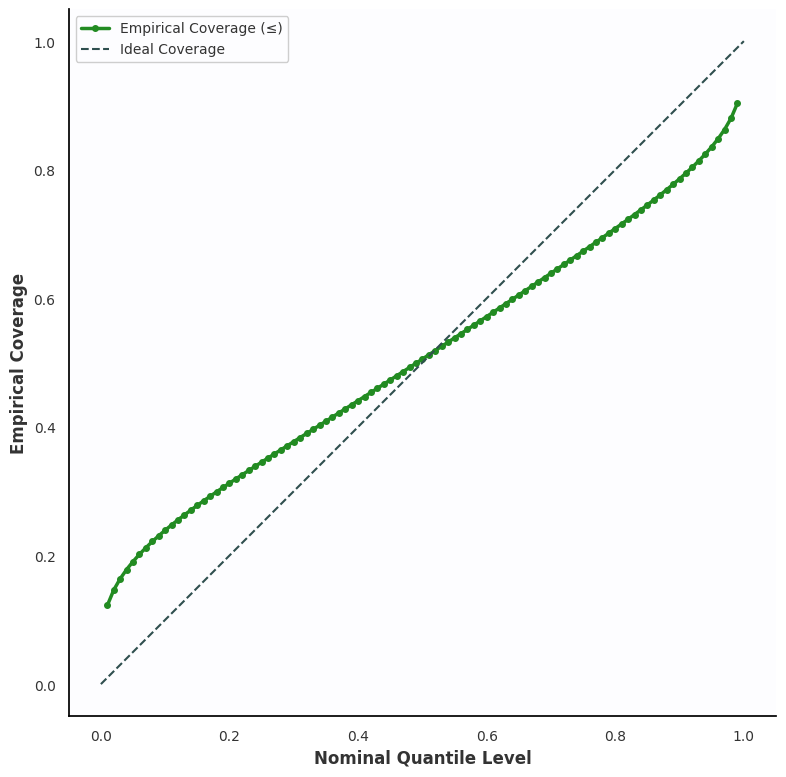

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def plot_quantile_coverage_seaborn(quantiles, future_actuals, quantile_levels, figsize=(8, 8),
                                  show_strict=False, show_diagonal=True):
    """
    Create a QQ plot showing the relationship between nominal and empirical quantile coverage using Seaborn styling.
    
    Parameters:
    -----------
    quantiles : array-like
        Predicted quantiles with shape (B, T, D, Q)
    future_actuals : array-like
        Actual values with shape (B, T, D)
    quantile_levels : array-like
        The quantile levels used in the forecast (e.g., [0.05, 0.1, ..., 0.95])
    figsize : tuple, optional
        Figure size (width, height) in inches
    show_strict : bool, optional
        Whether to also plot strict empirical coverage (< instead of ≤)
    show_diagonal : bool, optional
        Whether to show the ideal diagonal line
    title : str, optional
        Title for the plot
    """
    # Set custom color palette
    custom_palette = [
        "#228B22",  # ForestGreen
        "#006400",  # DarkGreen
        "#87CEFA",  # LightSkyBlue
        "#4169E1",  # RoyalBlue
        "#7B68EE",  # MediumSlateBlue
        "#9932CC",  # DarkOrchid
        "#2F4F4F",  # DarkSlateGray
        "#A52A2A",  # Brown
        "#DC143C",  # Crimson
        "#FF8C00"   # DarkOrange
    ]
    c_palette = sns.color_palette(custom_palette)
    
    # Set the custom Seaborn theme
    custom_text_color = "#333333"
    custom_bg = "#FDFDFF"
    
    custom_theme = {
        'axes.facecolor': custom_bg,
        "axes.spines.right": False, 
        "axes.spines.top": False,
        'axes.edgecolor': 'black',
        'axes.grid': False,
        'grid.color': '#dcdcdc',
        'grid.linestyle': '-',
        'xtick.color': custom_text_color,
        'ytick.color': custom_text_color,
        'axes.labelcolor': custom_text_color,
        'text.color': custom_text_color
    }
    sns.set_theme(style='white')
    sns.set_style("white", rc=custom_theme)
    
    # Convert torch tensors to numpy if needed
    if isinstance(quantiles, torch.Tensor):
        quantiles = quantiles.detach().cpu().numpy()
    if isinstance(future_actuals, torch.Tensor):
        future_actuals = future_actuals.detach().cpu().numpy()
    if isinstance(quantile_levels, torch.Tensor):
        quantile_levels = quantile_levels.detach().cpu().numpy()
        
    # Broadcast actuals to shape (B, T, D, Q)
    # actuals_broadcast = np.repeat(future_actuals[..., np.newaxis], quantiles.shape[-1], axis=-1)
    
    # Verify shapes match
    assert actuals_broadcast.shape == quantiles.shape, f"Shape mismatch: actuals_broadcast {actuals_broadcast.shape} vs quantiles {quantiles.shape}"
    
    # Empirical CDF values — indicator where actual ≤ predicted quantile
    hits = actuals_broadcast <= quantiles
    strict_hits = actuals_broadcast < quantiles
    
    # Compute coverage for each quantile level, averaging over batch, time, and features
    empirical_coverage = hits.mean(axis=(0, 1, 2))  # average over B, T, D
    strict_empirical_coverage = strict_hits.mean(axis=(0, 1, 2))  # average over B, T, D
    
    # Create figure with Seaborn styling
    fig, ax = plt.subplots(figsize=figsize)
    
    # Apply Seaborn's improved styling directly
    ax.set_facecolor(custom_bg)
    
    # Plot empirical coverage
    ax.plot(quantile_levels, empirical_coverage, 
           marker='o', linestyle='-', linewidth=2.5, markersize=4,
           color=c_palette[0], label='Empirical Coverage (≤)')
    
    # Plot strict empirical coverage if requested
    if show_strict:
        ax.plot(quantile_levels, strict_empirical_coverage, 
               marker='s', linestyle='--', linewidth=2, markersize=7,
               color=c_palette[1], label='Strict Coverage (<)')
    
    # Plot ideal diagonal line
    if show_diagonal:
        ax.plot([0, 1], [0, 1], linestyle='--', linewidth=1.5, 
               color=c_palette[6], label='Ideal Coverage')
    
    # Add error bands (difference from ideal)
    # error = np.abs(empirical_coverage - quantile_levels)
    # max_error = error.max()
    # ax.fill_between(quantile_levels, quantile_levels - max_error, quantile_levels + max_error,
    #                 color=c_palette[7], alpha=0.1, label=f'Max Error Band (±{max_error:.3f})')
    
    # Customize plot
    ax.set_xlabel('Nominal Quantile Level', fontsize=12, fontweight='bold')
    ax.set_ylabel('Empirical Coverage', fontsize=12, fontweight='bold')
    # ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Set axis limits
    buffer = 0.05
    ax.set_xlim(-buffer, 1 + buffer)
    ax.set_ylim(-buffer, 1 + buffer)
    
    # Add grid with custom styling
    # ax.grid(True, linestyle='--', alpha=0.6, color='#cccccc')
    
    # Add equal aspect ratio
    ax.set_aspect('equal')
    
    # Improve tick marks
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Add reference lines at 0 and 1
    # ax.axhline(y=0, color='#888888', linestyle='-', alpha=0.3)
    # ax.axhline(y=1, color='#888888', linestyle='-', alpha=0.3)
    # ax.axvline(x=0, color='#888888', linestyle='-', alpha=0.3)
    # ax.axvline(x=1, color='#888888', linestyle='-', alpha=0.3)
    
    # Add legend with improved styling
    legend = ax.legend(loc='upper left', frameon=True, framealpha=0.95,
                      fontsize=10, facecolor=custom_bg)
    # legend.get_frame().set_edgecolor('#888888')
    
    plt.tight_layout()
    
    return fig, ax

# Example usage:
# quantiles = np.random.normal(size=(10, 20, 7, 9))  # Example shape: (B=10, T=20, D=7, Q=9)
# future_actuals = np.random.normal(size=(10, 20, 7))  # Example shape: (B=10, T=20, D=7)
# quantile_levels = np.linspace(0.05, 0.95, 9)  # 9 quantile levels from 0.05 to 0.95
# 
fig, ax = plot_quantile_coverage_seaborn(quantiles, future_actuals, quantile_levels,
                                        show_strict=False, show_diagonal=True)
plt.show()